In [41]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [25]:
df = pd.read_csv("..\data_preprocessing\processed_dataset.csv")
df.head()
print(df['sentiment'].value_counts())
df = df.dropna(subset=['cleaned_review', 'sentiment'])

X = df['cleaned_review']
y = df['sentiment']

sentiment
positive    307625
negative     48822
neutral      28070
Name: count, dtype: int64


In [26]:
def tokenize(text):
    return text.split()

tokenized_reviews = X.apply(tokenize)

w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

In [27]:
def load_glove_embeddings(glove_file_path):
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as file:
        for line in tqdm(file, desc="Loading GloVe embeddings"):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings("glove.6B.100d.txt")

Loading GloVe embeddings: 400000it [00:05, 68164.44it/s]


In [28]:
def get_sentence_embedding(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X_word2vec = np.array([get_sentence_embedding(sent, w2v_model) for sent in tokenized_reviews])

In [29]:
def get_sentence_glove_embedding(sentence, embeddings):
    vectors = [embeddings[word] for word in sentence if word in embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X_glove = np.array([get_sentence_glove_embedding(sent, glove_embeddings) for sent in tokenized_reviews])

In [33]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, _, _ = train_test_split(X_glove, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_w2v = scaler.fit_transform(X_train_w2v)
X_test_w2v = scaler.transform(X_test_w2v)
X_train_glove = scaler.fit_transform(X_train_glove)
X_test_glove = scaler.transform(X_test_glove)

In [34]:
model_w2v = MultinomialNB()
model_glove = MultinomialNB()

In [38]:
# Train and predict with Word2Vec embeddings
model_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = model_w2v.predict(X_test_w2v)
print("Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_w2v))

# Train and predict with GloVe embeddings
model_glove.fit(X_train_glove, y_train)
y_pred_glove = model_glove.predict(X_test_glove)
print("GloVe Classification Report:")
print(classification_report(y_test, y_pred_glove))

Word2Vec Classification Report:


k:\Computer Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k:\Computer Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k:\Computer Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      9800
     neutral       0.00      0.00      0.00      5690
    positive       0.80      1.00      0.89     61376

    accuracy                           0.80     76866
   macro avg       0.27      0.33      0.30     76866
weighted avg       0.64      0.80      0.71     76866

GloVe Classification Report:


k:\Computer Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      9800
     neutral       0.00      0.00      0.00      5690
    positive       0.80      1.00      0.89     61376

    accuracy                           0.80     76866
   macro avg       0.27      0.33      0.30     76866
weighted avg       0.64      0.80      0.71     76866



k:\Computer Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k:\Computer Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


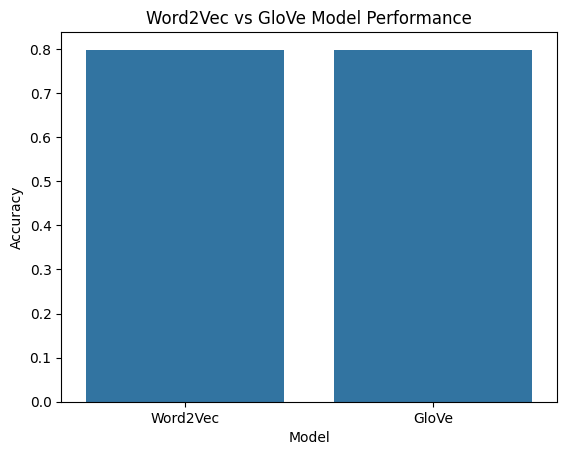

In [39]:
performance = pd.DataFrame({
    "Model": ["Word2Vec", "GloVe"],
    "Accuracy": [accuracy_score(y_test, y_pred_w2v), accuracy_score(y_test, y_pred_glove)]
})

sns.barplot(x="Model", y="Accuracy", data=performance)
plt.title("Word2Vec vs GloVe Model Performance")
plt.show()

In [ ]:
with open("w2v_embeddings.pkl", "wb") as f:
    pickle.dump(X_word2vec, f)

with open("glove_embeddings.pkl", "wb") as f:
    pickle.dump(X_glove, f)